In [1]:
import warnings
warnings.filterwarnings(action='ignore')
%config Completer.use_jedi = False

오토 인코더(Auto Encoder)

오토 인코더는 신경망의 한 종류로 입력 데이터를 코드(code)라고 부르는 은닉층을 인코딩하는 인코더(encoder) 부분과 인코딩된 코드를 다시 디코딩하는 디코더(Decoder)로 구성되어 있다. 인코딩은 원래 데이터를 차원 축소하는 것을 의미하고, 디코딩은 차원 축소된 데이터를 다시 원래 데이터로 복원하는 것을 의미한다.

<img src="./images/autoEncoder_1.png/" width="700"/>

오토 인코더의 시작은 차원 축소와 관련이 있는데 초기 오토 인코더는 주성분 분석과 같은 차원 축소를 위해 사용했지만, 현재는 데이터 생성 모형으로도 쓰인다.

In [4]:
# 일관된 결과값이 나오도록 random seed를 설정한다.
import numpy as np
import tensorflow as tf
np.random.seed(0)
tf.random.set_seed(0)

In [5]:
# 데이터 불러오기
from tensorflow.keras import datasets # 텐서플로우가 제공하는 데이터셋을 사용하기 위해 import 한다.
# mnist 손글씨 데이터는 트레이닝 데이터와 테스트 데이터가 나눠서 저장되어 있다.
# load_data() 메소드는 (트레이닝 피쳐 데이터, 트레이닝 타겟 데이터)와 (테스트 피쳐 데이터, 테스트 타겟 데이터)를
# 튜플 형태로 묶서러 리턴한다.
(X_train, y_train), (X_test, y_test) = datasets.mnist.load_data() # 손글씨 데이터셋을 피쳐, 타겟 데이터로 저장한다.

In [6]:
# 오리지널 데이터 확인 
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


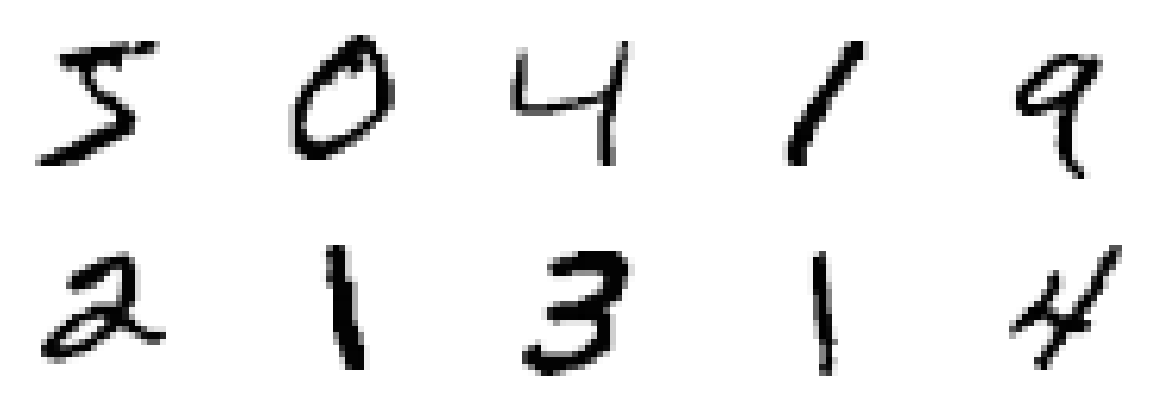

[5 0 4 1 9 2 1 3 1 4]


In [7]:
# 오리지날 데이터 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_train[i].reshape((28, 28)), cmap='Greys')
    plt.axis(False)
plt.show()
print(y_train[:10])

In [10]:
# 피처 데이터 스케일 조정
X_tn_re = X_train.reshape(60000, 28, 28, 1)
X_tn = X_tn_re / 255
print(X_tn.shape , X_tn_re.shape, X_tn.shape)
X_te_re = X_test.reshape(10000, 28, 28, 1)
X_te = X_te_re / 255
print(X_te.shape, X_te_re.shape, X_te.shape)

(60000, 28, 28, 1) (60000, 28, 28, 1) (60000, 28, 28, 1)
(10000, 28, 28, 1) (10000, 28, 28, 1) (10000, 28, 28, 1)


In [13]:
# 노이즈 피쳐 데이터
# 데이터셋에서 노이즈를 따로 제공하지 않으므로, 직접 노이즈 데이터를 생성한다.
# 오리지널 트레이닝 데이터에 랜덤값을 더해준다. 랜덤값은 np.random.uniform() 함수로 균등 분포에서 추출한다.
# 랜덤값은 -1부터 1 사이의 값을 가지며, 노이즈 배열의 크기는 트레이닝 데이터의 차원과 일치시켜 생성한다.
X_tn_noise = X_tn + np.random.uniform(-1, 1, size=X_tn.shape)
X_te_noise = X_te + np.random.uniform(-1, 1, size=X_te.shape)

In [14]:
# 노이즈 데이터 스케일링
# 노이즈 데이터를 생성하는 과정에서 픽셀값이 0 이하 혹은 1 이상이 되었을 가능성이 있어서 스케일을 조정한다.
# 넘파이의 clip() 함수를 사용하면 값의 범위를 조정할 수 있다.
# a_min=0, a_max=1로 설정하면 0 이하의 숫자는 0이 되고, 1 이상의 숫자는 1로 변환된다.
X_tn_ns = np.clip(X_tn_noise, a_min=0, a_max=1)
X_te_ns = np.clip(X_te_noise, a_min=0, a_max=1)

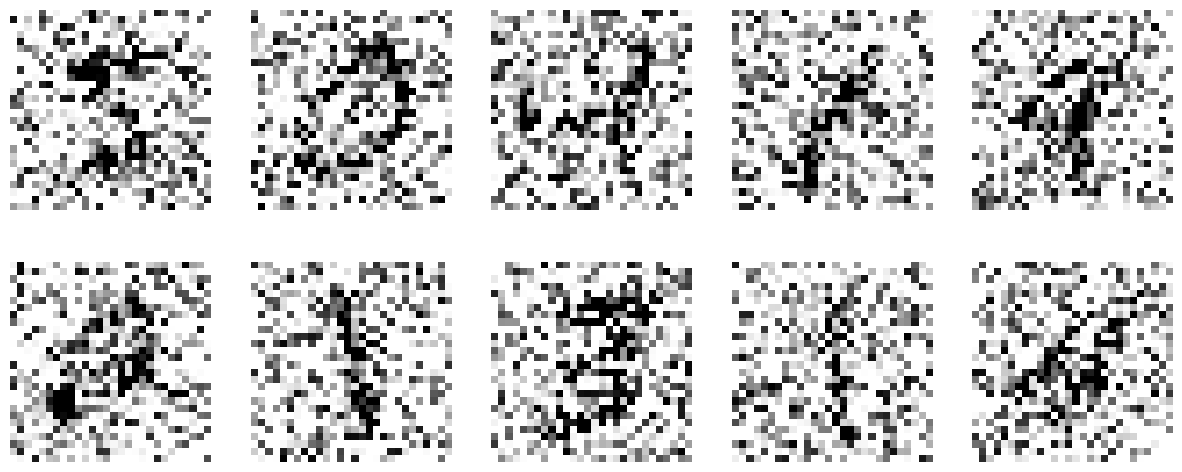

[5 0 4 1 9 2 1 3 1 4]


In [23]:
# 노이즈 데이터 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_tn_ns[i].reshape((28, 28)), cmap='Greys')
    plt.axis('off')
plt.show()
print(y_train[:10])

오토 인코더 신경망 모델을 만든다. 

In [27]:
# 함수형 API를 사용한 오토 인코더 신경망 모델 생성에 필요한 라이브러리 import 
from tensorflow.keras.models import Model # 함수형 API 신경망을 생성하기 위해 import 한다. 
from tensorflow.keras.layers import Input # 신경망에 추가할 입력 layer를 생성하기 위해 import 한다. 
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Activation # 신경망에 활성화 함수 layer를 생성하기 위해 import 한다. 
# 업셈플링이란 원래 이미지 크기로 복원하는 과정이다. 
# 다운샘플링은 이미지 크기를 줄여가며 특징을 추출하는과정이다. 
from tensorflow.keras.layers import UpSampling2D # 신경망에 업샘플링 layer를 생성하기 위해 import 한다.

In [29]:
# 인코더 모형 생성
# input layer의 Output Shape은 shape 속성값을 따른다. 
# input layer로 들어오는 데이터가 없기 때문에 Param 0 이다. 
input_layer1 = Input(shape=(28, 28, 1))
# padding='same' 옵션을 적용해 입력 이미지 크기와 출력 이미지 크기를 같게 한다.
x1 = Conv2D(filters=20, kernel_size=(5, 5), padding='same')(input_layer1)
# Param은 커널 크기(5 * 5) * 입력 채널(1) * 필터 크기(20) + 필터당 바이어스 개수(20) = 5 * 5 * 1 * 20 + 20 = 520
x1 = Activation(activation='relu')(x1)
output_layer1 = MaxPool2D(pool_size=(2, 2), padding='same')(x1)
encoder = Model(input_layer1, output_layer1)
encoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 20)        520       
                                                                 
 activation_1 (Activation)   (None, 28, 28, 20)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 20)       0         
 2D)                                                             
                                                                 
Total params: 520
Trainable params: 520
Non-trainable params: 0
_________________________________________________________________


In [30]:
# 인코더 출력 차원 확인
print(output_layer1.shape)
print(output_layer1.shape[0])
print(output_layer1.shape[1])
print(output_layer1.shape[2])
print(output_layer1.shape[3])
# 인코더 모형의 출력 차원을 확인해 본다. 이는 디코더 모형의 입력 사이즈로 적용된다.
print(output_layer1.shape[1:4])
print(output_layer1.shape[1:]) # 디코더 모델의 

(None, 14, 14, 20)
None
14
14
20
(14, 14, 20)
(14, 14, 20)


In [31]:
# 디코더 모형 생성
# 디코더의 입력층을 설정한다. 디코더 모형의 입력층 데이터 차원은 인코터 모형의 출력 차원과 같다.
input_layer2 = Input(shape=output_layer1.shape[1:4])
x2 = Conv2D(filters=10, kernel_size=(5, 5), padding='same')(input_layer2)
# Param은 커널 크기(5 * 5) * 입력 채널(20) * 필터 크기(10) + 필터당 바이어스 개수(10) = 5 * 5 * 20 * 10 + 10 = 5010
x2 = Activation(activation='relu')(x2)
# 줄어들었던 차원을 다시 높여준다.
x2 = UpSampling2D()(x2)
# 최종 출력 채널의 개수는 최초 입력 이미지의 채널 수와 같아야 하므로 1로 설정한다.
x2 = Conv2D(filters=1, kernel_size=(5, 5), padding='same')(x2)
# Param은 커널 크기(5 * 5) * 입력 채널(10) * 필터 크기(1) + 필터당 바이어스 개수(1) = 5 * 5 * 10 * 1 + 1 = 251
output_layer2 = Activation(activation='relu')(x2)
decoder = Model(input_layer2, output_layer2)
decoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 14, 14, 20)]      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 10)        5010      
                                                                 
 activation_2 (Activation)   (None, 14, 14, 10)        0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 28, 28, 10)       0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 1)         251       
                                                                 
 activation_3 (Activation)   (None, 28, 28, 1)         0         
                                                           

In [32]:
# 오토 인코더 모형 생성
# 오토 인코더는 최초의 입력값을 인코더에 먼저 넣고, 그 결과를 나온 출력을 다시 디코더에 넣은 결과이다.
input_auto = Input(shape=(28, 28, 1)) # 오토 인코더 모형의 입력층을 설정한다.
output_auto = decoder(encoder(input_auto)) # 오토 인코더의 최종 출력층을 설정한다.
auto_encoder = Model(input_auto, output_auto) # 입력층과 출력층을 넣어서 오토 인코더 모형을 생성한다.
auto_encoder.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 model_1 (Functional)        (None, 14, 14, 20)        520       
                                                                 
 model_2 (Functional)        (None, 28, 28, 1)         5261      
                                                                 
Total params: 5,781
Trainable params: 5,781
Non-trainable params: 0
_________________________________________________________________


In [33]:
# 모형 컴파일
auto_encoder.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

In [34]:
# 모형 학습
# 피쳐 데이터에는 노이즈가 추가된 X_tn_ns를 입력하고, 타겟 데이터에는 노이즈가 없는 오리지널 트레이닝 데이터
# X_tn를 넣어서 학습시킨다.
hist = auto_encoder.fit(X_tn_ns, X_tn, epochs=10, batch_size=100)

Epoch 1/10
600/600 [==============================] - 61s 101ms/step - loss: 0.0268 - mean_squared_error: 0.0268
Epoch 2/10
600/600 [==============================] - 60s 100ms/step - loss: 0.0217 - mean_squared_error: 0.0217
Epoch 3/10
600/600 [==============================] - 58s 97ms/step - loss: 0.0208 - mean_squared_error: 0.0208
Epoch 4/10
600/600 [==============================] - 60s 100ms/step - loss: 0.0200 - mean_squared_error: 0.0200
Epoch 5/10
600/600 [==============================] - 59s 98ms/step - loss: 0.0193 - mean_squared_error: 0.0193
Epoch 6/10
600/600 [==============================] - 62s 103ms/step - loss: 0.0181 - mean_squared_error: 0.0181
Epoch 7/10
600/600 [==============================] - 59s 99ms/step - loss: 0.0167 - mean_squared_error: 0.0167
Epoch 8/10
600/600 [==============================] - 59s 98ms/step - loss: 0.0157 - mean_squared_error: 0.0157
Epoch 9/10
600/600 [==============================] - 59s 98ms/step - loss: 0.0149 - mean_squared_er

In [35]:
# 학습한 모델로 예측
X_pred = auto_encoder.predict(X_tn_ns)

1875/1875 [==============================] - 22s 12ms/step


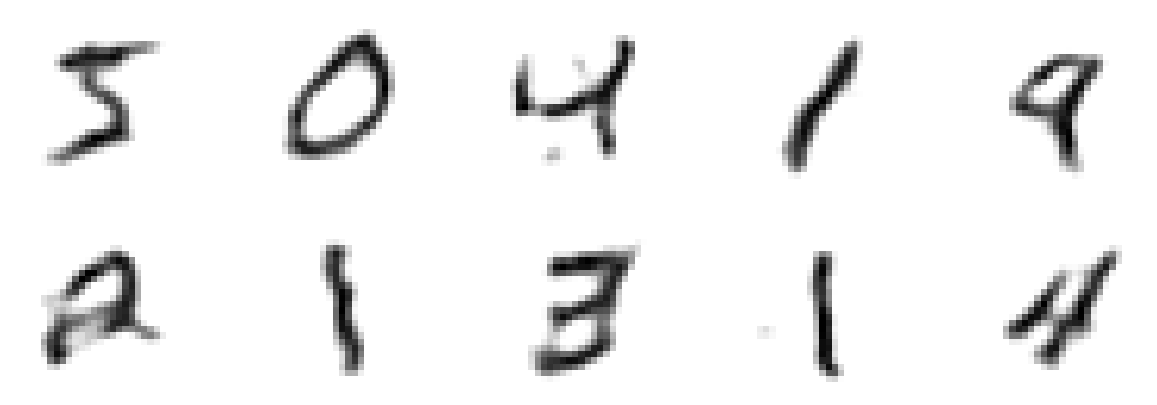

[5 0 4 1 9 2 1 3 1 4]


In [36]:
# 오토 인코딩 데이터 시각화
plt.figure(figsize=(15, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_pred[i].reshape((28, 28)), cmap='Greys')
    plt.axis(False)
plt.show()
print(y_train[:10])